In [1]:
# Import required packages
from distfit import distfit
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats

In [2]:
# Import data
data = pd.read_csv("../data/NHS_synthetic.csv", dtype={
    "ARRIVAL_TIME": str,
    "SERVICE_TIME": str,
    "DEPARTURE_TIME": str
})

# Preview data
data.head()


ARRIVAL_DATE ARRIVAL_TIME SERVICE_DATE SERVICE_TIME DEPARTURE_DATE  \
0   2025-01-01         0001   2025-01-01         0007     2025-01-01   
1   2025-01-01         0002   2025-01-01         0004     2025-01-01   
2   2025-01-01         0003   2025-01-01         0010     2025-01-01   
3   2025-01-01         0007   2025-01-01         0014     2025-01-01   
4   2025-01-01         0010   2025-01-01         0012     2025-01-01   

  DEPARTURE_TIME  
0           0012  
1           0007  
2           0030  
3           0022  
4           0031

In [4]:
# Calculate IAT
# Combine date/time and convert to datetime
data["arrival_datetime"] = pd.to_datetime(
    data["ARRIVAL_DATE"] + " " + data["ARRIVAL_TIME"].str.zfill(4),
    format="%Y-%m-%d %H%M"
)

# Sort by arrival time and calculate inter-arrival times
data = data.sort_values("arrival_datetime")
data["iat_mins"] = (
    data["arrival_datetime"].diff().dt.total_seconds() / 60
)

# Preview
data[["ARRIVAL_DATE", "ARRIVAL_TIME", "arrival_datetime", "iat_mins"]].tail(347)

ARRIVAL_DATE ARRIVAL_TIME    arrival_datetime  iat_mins
131569   2025-12-30         2336 2025-12-30 23:36:00       3.0
131570   2025-12-30         2346 2025-12-30 23:46:00      10.0
131571   2025-12-30         2359 2025-12-30 23:59:00      13.0
131572   2025-12-31         0004 2025-12-31 00:04:00       5.0
131573   2025-12-31         0006 2025-12-31 00:06:00       2.0
...             ...          ...                 ...       ...
131911   2025-12-31         2346 2025-12-31 23:46:00       8.0
131912   2025-12-31         2349 2025-12-31 23:49:00       3.0
131913   2025-12-31         2350 2025-12-31 23:50:00       1.0
131914   2025-12-31         2356 2025-12-31 23:56:00       6.0
131915   2025-12-31         2358 2025-12-31 23:58:00       2.0

[347 rows x 4 columns]

In [5]:
# Calculate Service Time
# Combine dates with times
data["service_datetime"] = pd.to_datetime(
    data["SERVICE_DATE"] + " " + data["SERVICE_TIME"].str.zfill(4)
)
data["departure_datetime"] = pd.to_datetime(
    data["DEPARTURE_DATE"] + " " + data["DEPARTURE_TIME"].str.zfill(4)
)

# Calculate time difference in minutes
time_delta = data["departure_datetime"] - data["service_datetime"]
data["service_mins"] = time_delta / pd.Timedelta(minutes=1)

# Preview
data[["service_datetime", "departure_datetime", "service_mins"]]

service_datetime  departure_datetime  service_mins
0      2025-01-01 00:07:00 2025-01-01 00:12:00           5.0
1      2025-01-01 00:04:00 2025-01-01 00:07:00           3.0
2      2025-01-01 00:10:00 2025-01-01 00:30:00          20.0
3      2025-01-01 00:14:00 2025-01-01 00:22:00           8.0
4      2025-01-01 00:12:00 2025-01-01 00:31:00          19.0
...                    ...                 ...           ...
131911 2025-12-31 23:50:00 2025-12-31 23:52:00           2.0
131912 2025-12-31 23:56:00 2026-01-01 00:02:00           6.0
131913 2025-12-31 23:51:00 2026-01-01 00:08:00          17.0
131914 2025-12-31 23:58:00 2026-01-01 00:03:00           5.0
131915 2026-01-01 00:07:00 2026-01-01 00:11:00           4.0

[131916 rows x 3 columns]

In [6]:
#  inspecting the data using time series plots and histograms.
def inspect_time_series(time_series, y_lab):
    """
    Plot time-series.

    Parameters
    ----------
    time_series : pd.Series
        Series containing the time series data (where index is the date).
    y_lab : str
        Y axis label.

    Returns
    -------
    fig : plotly.graph_objects.Figure
    """
    # Label as "Date" and provided y_lab, and convert to dataframe
    df = time_series.rename_axis("Date").reset_index(name=y_lab)

    # Create plot
    fig = px.line(df, x="Date", y=y_lab)
    fig.update_layout(showlegend=False, width=700, height=400)
    return fig

# Calculate mean arrivals per day and plot time series
p = inspect_time_series(
    time_series=data.groupby(by=["ARRIVAL_DATE"]).size(),
    y_lab="Number of arrivals")

p.show()


# Calculate mean service length per day, dropping last day (incomplete)
daily_service = data.groupby("SERVICE_DATE")["service_mins"].mean()
daily_service = daily_service.iloc[:-1]
# Plot mean service length each day
p = inspect_time_series(time_series=daily_service,
                        y_lab="Mean consultation length (min)")
p.show()

In [7]:
# Inspect the data by plotting a histogram
def inspect_histogram(series, x_lab):
    """
    Plot histogram.

    Parameters
    ----------
    series : pd.Series
        Series containing the values to plot as a histogram.
    x_lab : str
        X axis label.

    Returns
    -------
    fig : plotly.graph_objects.Figure
    """
    fig = px.histogram(series)
    fig.update_layout(
        xaxis_title=x_lab, showlegend=False, width=700, height=400
    )
    fig.update_traces(
        hovertemplate=x_lab + ": %{x}<br>Count: %{y}", name=""
    )
    return fig

# Plot histogram of inter-arrival times
p = inspect_histogram(series=data["iat_mins"],
                      x_lab="Inter-arrival time (min)")
p.show()

# Plot histogram of service times
p = inspect_histogram(series=data["service_mins"],
                      x_lab="Consultation length (min)")
p.show()

In [23]:
# Fit distributions and compare goodness-of fit - Kolmogorov-Smirnov (KS) Test
# Using scipy.stats

def fit_distributions(input_series, dists):
    """
    This function fits statistical distributions to the provided data and
    performs Kolmogorov-Smirnov tests to assess the goodness of fit.

    The KS Test returns a statistic and p value.

    Statistic: Measures how well the distribution fits your data.
    -Higher values indicate a better fit.
    - Ranges from 0 to 1.

    P-value: Tells you if the fit could have happened by chance.
    - Higher p-values suggest the data follow the distribution.
    - In large datasets, even good fits often have small p-values.
    - Ranges from 0 to 1.

    Parameters
    ----------
    input_series : pandas.Series
        The observed data to fit the distributions to.
    dists : list
        List of the distributions in scipy.stats to fit, eg. ["expon", "gamma"]

    Notes
    -----
    A lower test statistic and higher p-value indicates better fit to the data.
    """
    for dist_name in dists:
        # Fit distribution to the data
        dist = getattr(stats, dist_name)
        params = dist.fit(input_series)

        # Return results from Kolmogorov-Smirnov test
        ks_result = stats.kstest(input_series, dist_name, args=params)
        print(f"Kolmogorov-Smirnov statistic for {dist_name}: " +
            f"{ks_result.statistic:.4f} (p={ks_result.pvalue:.2e}) (p={ks_result.pvalue:.300f})")


# Fit and run Kolmogorov-Smirnov test on the inter-arrival and service times
distributions = ["expon", "gamma", "weibull_min"]

# Inter-arrival time:
fit_distributions(input_series=data["iat_mins"].dropna(), dists=distributions)

# Service time:
fit_distributions(input_series=data["service_mins"], dists=distributions)

Kolmogorov-Smirnov statistic for expon: 0.1155 (p=0.00e+00) (p=0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000)
Kolmogorov-Smirnov statistic for gamma: 0.2093 (p=0.00e+00) (p=0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000)
Kolmogorov-Smirnov statistic for weibull_min: 0.1355 (p=0.00e+00) (p=0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [18]:
# histograms from before but with the distributions overlaid
def inspect_histogram_with_fits(series, x_lab, dist_name):
    """
    Plot histogram with overlaid fitted distributions.

    Parameters
    ----------
    series : pd.Series
        Series containing the values to plot as a histogram.
    x_lab : str
        X axis label.
    dist_name : str
        Name of the distributions in scipy.stats to fit, eg. "expon"

    Returns
    -------
    fig : plotly.graph_objects.Figure
    """
    # Plot histogram with probability density normalisation
    fig = px.histogram(series, nbins=30, histnorm="probability density")
    fig.update_layout(
        xaxis_title=x_lab, showlegend=True, width=700, height=400
    )

    # Fit and plot each distribution
    x = np.linspace(series.min(), series.max(), 1000)
    dist = getattr(stats, dist_name)
    params = dist.fit(series.dropna())
    pdf_fitted = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])
    fig.add_trace(go.Scatter(x=x, y=pdf_fitted, mode="lines", name=dist_name))

    return fig

# Plot histograms with fitted distributions
p = inspect_histogram_with_fits(series=data["iat_mins"].dropna(),
                                x_lab="Inter-arrival time (min)",
                                dist_name="expon")
p.show()

p = inspect_histogram_with_fits(series=data["service_mins"],
                                x_lab="Service time (min)",
                                dist_name="expon")
p.show()

In [22]:
# Comprehensive approach - using distfit
# Fit popular distributions to inter-arrivals times
dfit_iat = distfit(distr="popular", stats="RSS", verbose="silent")
_ = dfit_iat.fit_transform(data["iat_mins"].dropna())
# Print summary of fitted distributions
print("IAT")
print(dfit_iat.summary)

# Fit popular distributions to service times
dfit_service = distfit(distr="popular", stats="RSS", verbose="silent")
_ = dfit_service.fit_transform(data["service_mins"])
# Print summary of fitted distributions
print("Service Times")
print(dfit_service.summary)

IAT
          name     score          loc       scale  \
0         beta  2.236862         -0.0  257.857868   
1        gamma  2.244529         -0.0    5.364842   
2        expon  2.248399          0.0    3.984361   
3       pareto  2.248399   -8388608.0   8388608.0   
4   genextreme  2.291064     1.894057    2.004986   
5            t  2.362306     2.912024    2.396901   
6     dweibull  2.382298     3.375977    2.986731   
7         norm  2.425599     3.984361    3.993252   
8     loggamma  2.428989 -1704.139387  215.557015   
9      uniform  2.756889          0.0        44.0   
10     lognorm  2.848256         -0.0         0.0   

                                         arg  \
0   (0.6881707915052352, 46.465037470261365)   
1                      (0.6842455772433067,)   
2                                         ()   
3                      (2105384.4506169236,)   
4                     (-0.3808426620405895,)   
5                       (2.693495828674275,)   
6                      

In [ ]:
# Use distfit with RSS but calculate a standard KS statistic using function below
def calculate_ks(input_series, dfit_summary):
    """
    Calculate standard Kolmogorov-Smirnov statistics for fitted distributions.

    This function applies the standard scipy.stats.kstest to data using the
    distribution parameters obtained from distfit, providing conventional
    KS statistics rather than distfit's resampling-based approach.

    Parameters
    ----------
    input_series : pandas.Series
        The original data series used for distribution fitting.
    dfit_summary : pandas.DataFrame
        The summary DataFrame from a distfit object, containing fitted
        distribution names and parameters.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the distribution names, KS statistics,
        and p-values from the standard KS test.

    Notes
    -----
    Lower KS statistic values indicate better fits to the data.
    """
    results = []
    for _, row in dfit_summary.iterrows():
        dist_name = row["name"]
        dist_params = row["params"]

        # Perform KS test using scipy.stats.kstest
        ks_result = stats.kstest(input_series, dist_name, args=dist_params)

        # Store the results
        results.append({
            "name": dist_name,
            "ks": ks_result.statistic[0],
            "p_value": ks_result.pvalue[0]
        })

    # Create a DataFrame with the results
    return pd.DataFrame(results).sort_values(by="ks")

print("Inter-arrival times with distfit and KS statistics:")
calculate_ks(input_series=data[["iat_mins"]].dropna(),
             dfit_summary=dfit_iat.summary)


Inter-arrival times with dfit and KS statistics:


name        ks  p_value
4   genextreme  0.115385      0.0
3       pareto  0.115461      0.0
2        expon  0.115461      0.0
6     dweibull  0.158115      0.0
5            t  0.160045      0.0
8     loggamma  0.177966      0.0
7         norm  0.179646      0.0
0         beta  0.199918      0.0
1        gamma  0.209314      0.0
10     lognorm  0.523766      0.0
9      uniform  0.703668      0.0

In [ ]:
print("Service times with distfit and KS statistics:")
calculate_ks(input_series=data[["service_mins"]],
             dfit_summary=dfit_service.summary)

Service times with dfit and KS statistics:


name        ks        p_value
1       pareto  0.047970  3.085744e-264
0        expon  0.047970  3.084811e-264
3   genextreme  0.070976   0.000000e+00
2         beta  0.092610   0.000000e+00
4        gamma  0.122569   0.000000e+00
7         norm  0.158105   0.000000e+00
5            t  0.160056   0.000000e+00
8     loggamma  0.161955   0.000000e+00
6     dweibull  0.175325   0.000000e+00
10     lognorm  0.536170   0.000000e+00
9      uniform  0.713362   0.000000e+00

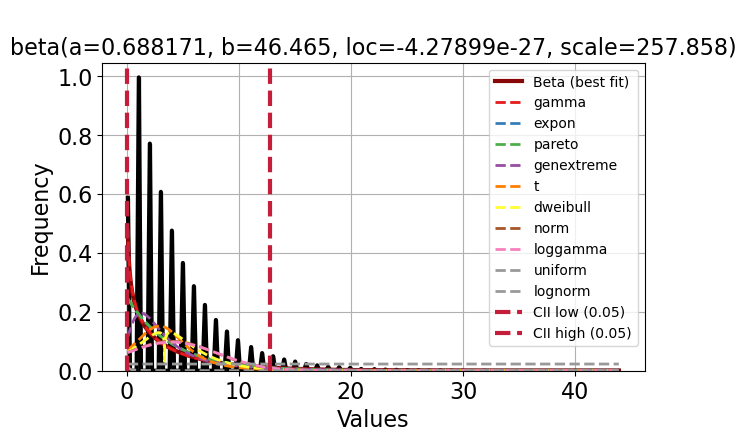

In [32]:
# PDF with all the distributions overlaid
p, _ = dfit_iat.plot(n_top=11, figsize=(7, 4))
p.show()

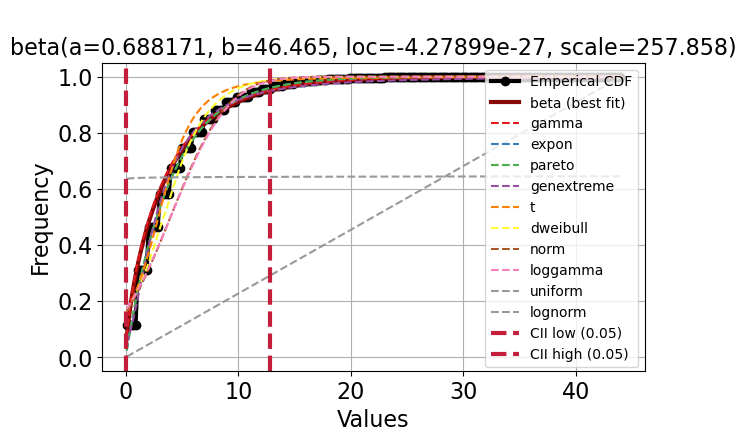

In [33]:
# CDF with all the distributions overlaid
p, _ = dfit_iat.plot(chart="cdf", n_top=11, figsize=(7, 4))
p.show()

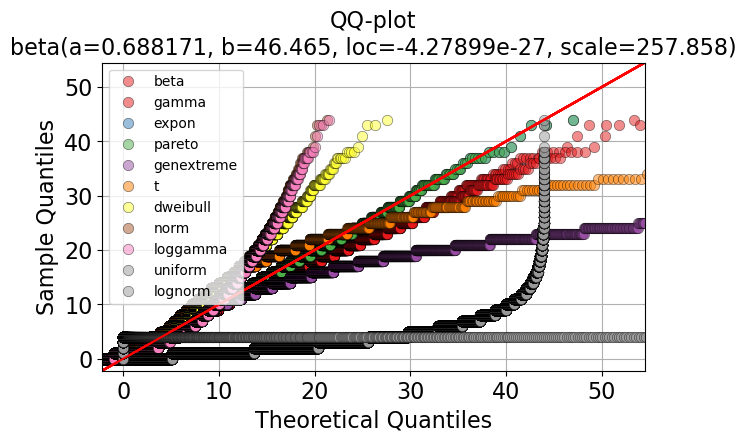

In [34]:
# QQ plot with all distributions overlaid
p, _ = dfit_iat.qqplot(data["iat_mins"].dropna(), n_top=11, figsize=(7, 4))
p.show()

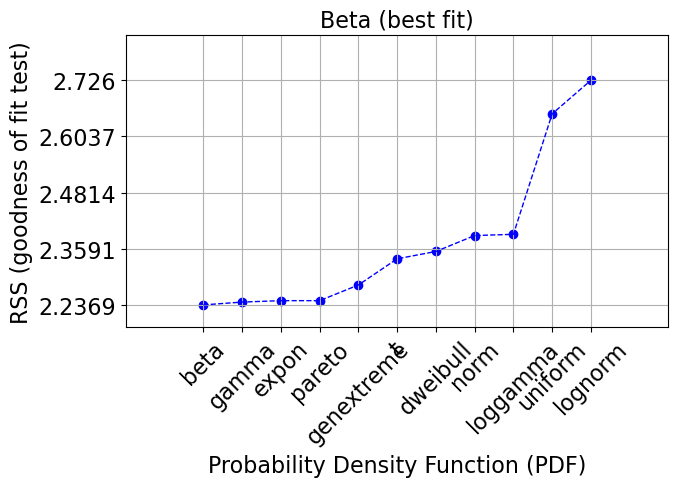

In [35]:
# Summary plot using the RSS
p, _ = dfit_iat.plot_summary(figsize=(7, 4))
p.show()

[15-07-2025 13:20:06] [distfit.distfit] [INFO] fit
[15-07-2025 13:20:06] [distfit.distfit] [INFO] transform
[15-07-2025 13:20:06] [distfit.distfit] [INFO] [expon] [0.00 sec] [RSS: 2.2484] [loc=0.000 scale=3.984]
[15-07-2025 13:20:06] [distfit.distfit] [INFO] [expon] [0.00 sec] [RSS: 2.2484] [loc=0.000 scale=3.984]
[15-07-2025 13:20:06] [distfit.distfit] [INFO] Compute confidence intervals [parametric]
[15-07-2025 13:20:06] [distfit.distfit] [INFO] Create pdf plot for the parametric method.
[15-07-2025 13:20:06] [distfit.distfit] [INFO] Estimated distribution: Expon(loc:0.000000, scale:3.984361)


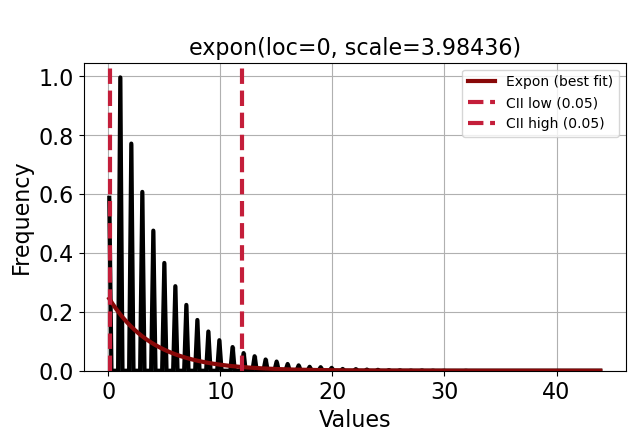

In [36]:
# To create a plot with a specific distribution overlaid...
dfit = distfit(distr="expon")
_ = dfit.fit_transform(data["iat_mins"].dropna())
p, _ = dfit.plot(figsize=(7, 4))
p.show()

In [39]:
# We will use the Exponential class from sim-tools, which uses the numpy.random.exponential() function. That accepts the scale parameter, so we just need to calculate the sample mean.
print(data["iat_mins"].dropna().mean())
print(data["service_mins"].dropna().mean())

3.9843611416442406
9.991570393280572
